# The Data!


<AxesSubplot:xlabel='eruptions', ylabel='waiting'>

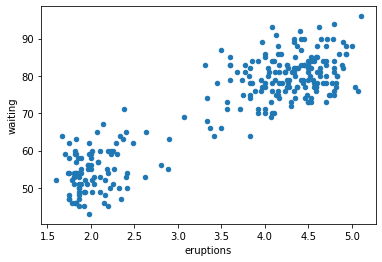

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv", sep = "\t")
data.head()
data.plot.scatter(0,1)


- observed data: $y_1, \ldots, y_n$ (bivariate)
- $y_i = (y_i^1, y_i^2) = (\text{eruption}^i, \text{waiting}^i)$


# The Model

### Gaussian mixtures likelihood


- $x_i$: binary...whether it came from first normal distribution, or second
- $\theta = (\mu_0, \Lambda_0, \mu_1, \Lambda_1, \pi)$ mixture weight and parameters of all normal distributions


$$
p(y_i \mid x_i = 0, \theta) = \text{Normal}
\left(
\mu_0, 
\Sigma_0
\right)
= \text{Normal}
\left(
\mu_0, 
\Lambda_0^{-1}
\right)
$$
$$
p(y_i \mid x_i = 1, \theta) = \text{Normal}
\left(
\mu_1, 
\Sigma_1
\right)
= \text{Normal}
\left(
\mu_1, 
\Lambda_1^{-1}
\right)
$$
$$
x_i \mid \pi \sim \text{Bernoulli}(\pi)
$$

here $\mu_0$ and $\mu_1$ are $2 \times 1$ vectors, and $\Sigma_0$ and $\Sigma_1$ are $2 \times 2$ covariance matrices. $\Lambda_i$ are both precision matrices. $0 < \pi < 1$. 

We assume all data points are exchangeable/iid:

$p(\mathbf{y} \mid \mathbf{x}, \theta) := \prod_{i=1}^n p(y_i \mid x_i, \theta)$ 

$p(\mathbf{x} \mid \theta) = \prod_{i=1}^n p(x_i \mid \theta)$

### The Prior

We'll use precision matrices throughout the rest of this demo. For $i=0,1$:


- $\mu_i\mid \Lambda_i \sim \text{Normal}(\mu^*, [\beta^* \Lambda_i]^{-1})$, 
- $\Lambda_i \sim \text{Wishart}(\mathbf{W}, \nu)$
- $\pi \sim \text{Beta}(a,b)$

we'll package up the prior hyperparameters in the following order: $(\mu^*, \beta^*, \mathbf{W}, \nu,a,b)$

# A Variational Approximation of $p(\theta, \mathbf{X} \mid \mathbf{y})$




## Initializing our Approximation 
Let's pick our approximating class of distributions:

\begin{align*}
g(\mathbf{x}, \theta) 
&= g(\mathbf{x}, \pi, \mu_0, \mu_1, \Lambda_0, \Lambda_1) \\
&= g(\mathbf{x})g(\pi)g(\mu_0, \Lambda_0)g(\mu_1, \Lambda_1) \\
&= g(\mathbf{x})g(\pi)g(\mu_0, \Lambda_0)g(\mu_1, \Lambda_1)
\end{align*}

Specifically:

- $g(\mathbf{x}) = \prod_{i=1}^n \text{Bernoulli}(p_i)$
- $g(\pi) = \text{Beta}(\alpha, \beta)$
- $g(\mu_0, \Lambda_0) = g(\mu_0 \mid \Lambda_0)g(\Lambda_0) = \text{Normal}(m_0, [c_0 \Lambda_0]^{-1})\text{Wishart}(\mathbf{H}_0, \tau_0)$
- $g(\mu_1, \Lambda_1) = g(\mu_1 \mid \Lambda_1)g(\Lambda_1) = \text{Normal}(m_1, [c_1 \Lambda_1]^{-1})\text{Wishart}(\mathbf{H}_1, \tau_1)$

We want to keep changing the "hyperparameters" $\{p_i\}_i, \alpha, \beta, m_0, m_1, c_0, c_1, \mathbf{H}_0, \mathbf{H}_1, \tau_0, \tau_1$ until they make a distribution that is very close to our posterior. At every iteration of our algorithm, we'll make changes to these hyperparameters, which is the same as making changes to $g$ distributions. 

## The ELBO

After applying Bayes' rule, our target is:
$$
p(\theta, \mathbf{x} \mid \mathbf{y}) \propto
p(\mathbf{y} \mid \mathbf{x}, \theta) p(\mathbf{x} \mid \theta) p(\theta)
$$
and after taking the log on both sides:
\begin{align*}
\log p(\theta, \mathbf{x} \mid \mathbf{y}) 
&= \log p(\mathbf{y} \mid \mathbf{x}, \theta) + \log p(\mathbf{x} \mid \theta) + \log p(\theta) + \text{constant} \\
&= \sum_{i=1}^n \left[ \log p(y_i \mid x_i, \theta) + \log p(x_i \mid \theta)\right] + \log p(\theta) + c \\
&= \sum_{i=1}^n \sum_{j=0}^1  \mathbb{I}(x_i = j) \left[ \log p(y_i \mid x_i=j, \theta) + \log p(x_i=j \mid \theta)\right] + \log p(\theta) + c
\end{align*}

The above quantity is not easy to take expectations of because we don't know $c$. But $c$ doesn't have anything to do with the parameters, so we'll drop it. In other words, this algorithm will take expectations of the following (i.e. the same quantity as the EM algorithm): 

\begin{align*}
\log p(\mathbf{y}, \mathbf{x}, \theta ) 
&= \sum_{i=1}^n \sum_{j=0}^1  \mathbb{I}(x_i = j) \left[ \log p(y_i \mid x_i=j, \theta) + \log p(x_i=j \mid \theta)\right] + \log p(\theta)
\end{align*}


Recall that the expectation of this is sometimes referred to as the ELBO.You can maximize the ELBO, or you can, like us, minimize the negative ELBO.



## Coordinate Ascent Variational Inference (CAVI)

The VI algorithm will alternative between each $g$ factor, and update individual components of the approximating distribution. Each update formula must be derived, and it generally requires a bunch of math. We'll go through and prove each formula, but feel free to skip all the mathematical details on a first reading. 

### 1. changing $\mathbf{x}$'s distribution at each iteration

Every iteration we will cycle through all of our $g$ distributions, and make changes to each one. We'll start off by describing how we make changes to $\mathbf{x}$. This is the formula:

\begin{align*}
\tilde{p}(\mathbf{x}) 
&= \exp[\mathbb{E}_{-\mathbf{x}}\{\log p(\mathbf{y}, \mathbf{x}, \theta ) \} ] \\
&= \prod_{i=1}^n \tilde{p}(x_i)
\end{align*}


Here we take the expectation with respect to 
$$
g(\pi)g(\mu_0 \mid \Lambda_0)g(\mu_1 \mid \Lambda_1)g(\Lambda_0)g(\Lambda_1).
$$ 

In other words, we take the expectation with respect to the approximate distribution of everything except $\mathbf{x}$


\begin{align*}
\mathbb{E}_{-\mathbf{x}}\{\log p(\mathbf{y}, \mathbf{x}, \theta ) \}
&=
\sum_{i=1}^n  
\mathbb{E}_{-\mathbf{x}} \left[\log p(y_i \mid x_i, \theta)\right] 
+ \mathbb{E}_{-\mathbf{x}}\left[\log p(x_i \mid \theta)\right]
\end{align*}

We can focus on one $i$ at a time, because the exponential of the above will factor. For each $i$, we're taking the expectation of two pieces:

$$
\log p(y_i \mid x_i, \theta) =
-\log(2\pi) + .5 \log \det \Lambda_{x_i} - .5 (y_i - \mu_{x_i})^\intercal \Lambda_{x_i}(y_i - \mu_{x_i})
$$

and
$$
\log p(x_i  \mid \theta) = x_i \log \pi + (1-x_i)\log(1-\pi) 
$$




Taking the expectation of the first piece is a little more difficult, but there are some formulas from Wiki (e.g. [1](https://en.wikipedia.org/wiki/Wishart_distribution#Log-expectation) and [2](https://en.wikipedia.org/wiki/Multivariate_gamma_function) and [3](https://en.wikipedia.org/wiki/Quadratic_form_(statistics)#Expectation) and [4](https://en.wikipedia.org/wiki/Law_of_total_expectation) and [5](https://en.wikipedia.org/wiki/Trace_(linear_algebra)). ) we can take advtange of. Remember that any summand that's free of $\mathbf{x}$ can be disregarded as an additive constant that will be taken care of later when we figure out the normalizing constant.

\begin{align*}
\mathbb{E}_{-\mathbf{x}}[
\log p(y_i \mid x_i, \theta)] 
&=
-\log(2\pi) + .5 \mathbb{E}_{-\mathbf{x}}[  \log \det \Lambda_{x_i}] 
- .5 \mathbb{E}_{-\mathbf{x}}[ (y_i - \mu_{x_i})^\intercal \Lambda_{x_i}(y_i - \mu_{x_i})] ] \\
&=
c + .5 \left\{ \psi_2(\tau_{x_i}/2)  + 2 \log (2) + \log \det \mathbf{H}_{x_i} \right\} 
- .5 \mathbb{E}_{-\mathbf{x}}[ (y_i - \mu_{x_i})^\intercal \Lambda_{x_i}(y_i - \mu_{x_i})] ] \\
&=
c + .5 \left\{ 
\psi(\tau_{x_i}/2 ) + \psi((\tau_{x_i}-1)/2  )\right\}
- .5 \mathbb{E}_{-\mathbf{x}}[ (y_i - \mu_{x_i})^\intercal \Lambda_{x_i}(y_i - \mu_{x_i})] ]\\
&=
c + .5 \left\{ 
\psi(\tau_{x_i}/2 ) + \psi((\tau_{x_i}-1)/2  )\right\}
- .5 \mathbb{E}_{\Lambda} \left\{ \mathbb{E}_{\mu \mid \Lambda}[ (y_i - \mu_{x_i})^\intercal \Lambda_{x_i}(y_i - \mu_{x_i})] ]\right\} \\
&=
c + .5 \left\{ 
\psi(\tau_{x_i}/2 ) + \psi((\tau_{x_i}-1)/2  )\right\}
- .5 \mathbb{E}_{\Lambda} \left\{ \text{tr}(\Lambda_{x_i}\Lambda_{x_i}^{-1} )/c_{x_i} + (m_{x_i} - y_i)^\intercal\Lambda_{x_i}(m_{x_i} - y_i) \right\} \\
&=
c + .5 \left\{ 
\psi(\tau_{x_i}/2 ) + \psi((\tau_{x_i}-1)/2  )\right\}
- .5 \mathbb{E}_{\Lambda} \left\{ 2/c_{x_i} + (m_{x_i} - y_i)^\intercal\Lambda_{x_i}(m_{x_i} - y_i) \right\} \\
&=
c + .5 \left\{ 
\psi(\tau_{x_i}/2 ) + \psi((\tau_{x_i}-1)/2  )\right\}
- .5  \left\{ 2/c_{x_i} + (m_{x_i} - y_i)^\intercal \mathbb{E}_{\Lambda}[ \Lambda_{x_i}](m_{x_i} - y_i) \right\} \\
&=
c + .5 \left\{ 
\psi(\tau_{x_i}/2 ) + \psi((\tau_{x_i}-1)/2  )\right\}
- .5  \left\{ 2/c_{x_i} + (m_{x_i} - y_i)^\intercal \mathbf{H}_{x_i} \tau_{x_i} (m_{x_i} - y_i) \right\}
\end{align*}





Taking the expectation of the second piece also requires some [math-stats formulae](https://en.wikipedia.org/wiki/Beta_distribution#Moments_of_logarithmically_transformed_random_variables):

\begin{align*}
\mathbb{E}_{-\mathbf{x}}[ \log p(x_i  \mid \theta)] 
&= x_i \mathbb{E}_{-\mathbf{x}} \log \pi + (1-x_i)\mathbb{E}_{-\mathbf{x}}\log(1-\pi) \\
&= x_i [\psi(\alpha) - \psi(\alpha + \beta)] + (1-x_i)[\psi(\beta) - \psi(\alpha + \beta)] \\
\end{align*}

Both of these functions involve the "digamma function" which is [available in Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.digamma.html). The $\psi_2$ with a subscript in it is multivariate digamma which is a bit different.


<!-- Putting it all together:

\begin{align*}
&\mathbb{E}_{-\mathbf{x}}\{\log p(\mathbf{y}, \mathbf{x}, \theta ) \}\\
&= 
\sum_{i=1}^n 
-\log(2\pi) + .5 \left\{ 
\psi(\tau_{x_i}/2 ) + \psi((\tau_{x_i}-1)/2  )
+ 2 \log (2) + \log \det \mathbf{H}_{x_i} \right\} 
- .5 \left\{ (y_i - m_{x_i})^\intercal ] \tau_{x_i} \mathbf{H}_{x_i} (y_i - m_{x_i})   \right\}
+ x_i [\psi(\alpha) - \psi(\alpha + \beta)] + (1-x_i)[\psi(\beta) - \psi(\alpha + \beta)] \\
&= c +
\sum_{i=1}^n 
.5 \log \det \mathbf{H}_{x_i} 
- .5 \left\{ (y_i - m_{x_i})^\intercal ] \tau_{x_i} \mathbf{H}_{x_i} (y_i - m_{x_i})   \right\}
+ x_i [\psi(\alpha) - \psi(\alpha + \beta)] + (1-x_i)[\psi(\beta) - \psi(\alpha + \beta)]
+ .5 \psi(\tau_{x_i}/2 ) + .5\psi((\tau_{x_i}-1)/2  )
\end{align*}
 -->
All that's left is that you have to exponentiate this, and then normalize. Normalization is easy because we can just divide by the sum of the unnormalized probabilities. 

\begin{align*}
\tilde{p}(\mathbf{x}) 
&= \exp[\mathbb{E}_{-\mathbf{x}}\{\log p(\mathbf{y}, \mathbf{x}, \theta ) \} ] \\
&= \prod_{i=1}^n \tilde{p}(x_i)
\end{align*}



In [2]:
from scipy.stats import multivariate_normal
from scipy.special import digamma

def update_x(old_g_hyper_params, ydata, prior):
    """this function takes and old g approx posterior
    and then returns a new g approx posterior
    the new one will have updated p probabilities
    NB: we only keep track of the probability that 
    xi is 1. but in order to get this, you need to 
    compute both and then normalize"""
    # unpackage g and prior hyper parameters
    mu_star, beta_star, W, nu, a, b = prior
    old_p_array, alpha, beta, m_zero, m_one, c_zero, c_one, H_zero, H_one, tau_zero, tau_one = old_g_hyper_params

    new_p_array = np.empty(old_p_array.shape)
    tmp = np.empty((2,))
    row = 0
    
    for idx,yi in ydata.iterrows():
        # compute log of unnormalized probabilities
        first_log_unnorm  = .5*(digamma(.5*tau_zero) + digamma(.5*(tau_zero-1)))
        first_log_unnorm -= 1/c_zero 
        first_log_unnorm -= .5*tau_zero * (np.transpose(m_zero - yi.values) @ H_zero @ (m_zero - yi.values))
        first_log_unnorm += digamma(alpha) - digamma(alpha + beta)
        
        secnd_log_unnorm  = .5*(digamma(.5*tau_one) + digamma(.5*(tau_one-1)))
        secnd_log_unnorm -= 1/c_one 
        secnd_log_unnorm -= .5*tau_one * (np.transpose(m_one - yi.values) @ H_one @ (m_one - yi.values))
        secnd_log_unnorm += digamma(beta) - digamma(alpha + beta)
        
        # now convert log unnorm probabilities into probabilities
        m = np.max([first_log_unnorm, secnd_log_unnorm])
        first_log_unnorm -= m
        secnd_log_unnorm -= m
        tmp[0] = np.exp(first_log_unnorm)
        tmp[1] = np.exp(secnd_log_unnorm)
        tmp = tmp/np.sum(tmp)
        
        # store the probability that xi is 1 (ignore the other becuase they sum to 1)
        new_p_array[row] = tmp[1]
        row += 1
    return (new_p_array, alpha, beta, m_zero, m_one, c_zero, c_one, H_zero, H_one, tau_zero, tau_one)

### 2. changing $\pi$'s distribution at each iteration

Here we take the expectation of 

\begin{align*}
\log p(\mathbf{y}, \mathbf{x}, \theta ) 
&= \sum_{i=1}^n  \left[ \log p(y_i \mid x_i=j, \theta) + \log p(x_i=j \mid \theta)\right] + \log p(\theta)\\
&= c + \sum_{i=1}^n   x_i \log \pi + (1-x_i)\log(1-\pi) + \log p(\theta) \\
&= c + \sum_{i=1}^n   x_i \log \pi + (1-x_i)\log(1-\pi) + \log [\pi^{a-1}(1-\pi)^{b-1}] \\
&= c + \sum_{i=1}^n   x_i \log \pi + (1-x_i)\log(1-\pi) + (a-1)\log \pi + (b-1)\log(1-\pi) \\
&= (\sum_i x_i + a - 1)\log \pi + (n - \sum_i x_i + b - 1)\log(1-\pi)
\end{align*}




with respect to 
$$
g(\mathbf{x})g(\mu_0 \mid \Lambda_0)g(\mu_1 \mid \Lambda_1)g(\Lambda_0)g(\Lambda_1).
$$ 

This is easier than updating the other components.

\begin{align*}
\tilde{p}(\pi) 
&= \exp[\mathbb{E}_{-\pi}\{\log p(\mathbf{y}, \mathbf{x}, \theta ) \} ] \\
\end{align*}

and focusing on the exponent:

\begin{align*}
\mathbb{E}_{-\pi}\{\log p(\mathbf{y}, \mathbf{x}, \theta ) \}
&= \mathbb{E}_{-\pi}(\sum_i x_i + a - 1) \log \pi + \mathbb{E}_{-\pi}(n - \sum_i x_i + b - 1)\log(1-\pi)\\
&= (\sum_i p_i + a - 1) \log \pi + (n - \sum_i p_i + b - 1)\log(1-\pi)
\end{align*}

and we end up with a Beta distribution. 

In [3]:
def update_pi(old_g_hyper_params, ydata, prior_hyperparams):
    """this function takes and old g approx posterior
    and then returns a new g approx posterior
    the new one will have updated alpha and betas"""
    mu_star, beta_star, W, nu, a, b = prior_hyperparams
    p_array, old_alpha, old_beta, m_zero, m_one, c_zero, c_one, H_zero, H_one, tau_zero, tau_one = old_g_hyper_params
    sum_ps = np.sum(p_array)   
    return (p_array, sum_ps + a, ydata.shape[0] - sum_ps + b, m_zero, m_one, c_zero, c_one, H_zero, H_one, tau_zero, tau_one)


### 3. changing $\mu_0$ and $\Lambda_0$'s distribution at each iteration


Here we take the expectation of 

\begin{align*}
\log p(\mathbf{y}, \mathbf{x}, \theta ) 
&= \sum_{i=1}^n  \sum_{j=0}^2 \mathbb{I}(x_i = j)\left[ \log p(y_i \mid x_i=j, \theta) + \log p(x_i=j \mid \theta)\right]  + \log p(\theta)\\
&= c + \sum_{i=1}^n  \mathbb{I}(x_i = 0)\left[ \log p(y_i \mid x_i=0, \theta) + \log p(x_i=0 \mid \theta)\right]  + \log p(\mu_0 \mid \Lambda_0) + \log p(\Lambda_0) \\
&= c + \sum_{i=1}^n  \mathbb{I}(x_i = 0)\log p(y_i \mid x_i=0, \theta)  + \log p(\mu_0 \mid \Lambda_0) + \log p(\Lambda_0)
\end{align*}



with respect to 
$$
g(\mathbf{x})g(\pi)g(\mu_1 \mid \Lambda_1)g(\Lambda_1).
$$ 

Most of the things we're integrating with respect to aren't present, so it's relatively simple to take the expectation:

\begin{align*}
&\mathbb{E}_{-(\mu_0, \Lambda_0)}
\left[
\sum_{i=1}^n  \mathbb{I}(x_i = 0)\log p(y_i \mid x_i=0, \theta) 
+\log p(\mu_0 \mid \Lambda_0) + \log p(\Lambda_0)
\right] \\
&= 
\mathbb{E}_{-(\mu_0, \Lambda_0)}
\left[
\sum_{i=1}^n  \mathbb{I}(x_i = 0)\left[ \log p(y_i \mid x_i=0, \theta) \right]
\right] 
+\log p(\mu_0 \mid \Lambda_0) + \log p(\Lambda_0) + c
\\
&\mathbb{E}_{-(\mu_0, \Lambda_0)}
\left[
\sum_{i=1}^n  \mathbb{I}(x_i = 0)\left[  .5 \log \det \Lambda_{0} - .5 (y_i - \mu_{0})^\intercal \Lambda_{0}(y_i - \mu_{0})]  \right] \right]  
+\log p(\mu_0 \mid \Lambda_0) + \log p(\Lambda_0)+ c\\
&= 
\sum_{i=1}^n  (1-p_i) \left[  .5 \log \det \Lambda_{0} - .5 (y_i - \mu_{0})^\intercal \Lambda_{0}(y_i - \mu_{0})]  \right] 
+\log p(\mu_0 \mid \Lambda_0) + \log p(\Lambda_0)+ c
\end{align*}




The more difficult part is rearranging this into the appropriate Normal-Wishart distribution. Let's write it all out at first and then we can group terms together. Again we make use of some properties of the [trace operator](https://en.wikipedia.org/wiki/Trace_(linear_algebra)).




\begin{align*}
&\sum_{i=1}^n  (1-p_i) \left[  .5 \log \det \Lambda_{0} - .5 (y_i - \mu_{0})^\intercal \Lambda_{0}(y_i - \mu_{0})]  \right] + .5 \log \det \Lambda_0 - .5 \beta^*(\mu_0 - \mu^*)^\intercal\Lambda_0(\mu_0 - \mu^*) \\
&\hspace{10mm} + 
.5*(\nu-2-1)\log \det \Lambda_0 - .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\
&= .5 \log \det \Lambda_{0} 
\left\{ \sum_{i=1}^n  (1-p_i) + 1 + \nu-2-1 \right\}
- .5 \sum_{i=1}^n  (1-p_i) (y_i - \mu_{0})^\intercal \Lambda_{0}(y_i - \mu_{0})   \\
&\hspace{10mm} 
- .5 \beta^*(\mu_0 - \mu^*)^\intercal\Lambda_0(\mu_0 - \mu^*) - .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\
&= .5 \log \det \Lambda_{0} 
\left\{ \sum_{i=1}^n  (1-p_i) + 1 + \nu-2-1 \right\}
- .5 \sum_{i=1}^n  (1-p_i) (\mu_{0} - y_i )^\intercal \Lambda_{0}(\mu_{0}- y_i )   \\
&\hspace{10mm} 
- .5 \beta^*(\mu_0 - \mu^*)^\intercal\Lambda_0(\mu_0 - \mu^*) - .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\
\end{align*}

The second chunk is tedious to simplify

\begin{align*}
\sum_{i=1}^n  (1-p_i) (\mu_{0} - y_i )^\intercal \Lambda_{0}(\mu_{0}- y_i ) 
&=
\sum_{i=1}^n  (1-p_i) \left[ (\mu_{0}^\intercal \Lambda_{0}\mu_{0} - 2 \mu_0^\intercal \Lambda_0 y_i + y_i^\intercal \Lambda_0 y_i \right] \\
&=
\sum_{i=1}^n  (1-p_i) \mu_{0}^\intercal \Lambda_{0}\mu_{0} - 2 \sum_{i=1}^n  (1-p_i)\mu_0^\intercal \Lambda_0 y_i + \sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i  \\
&=
\mu_{0}^\intercal s_n \Lambda_{0}\mu_{0} - 2 \mu_0^\intercal s_n \Lambda_0\sum_{i=1}^n  (1-p_i) \frac{y_i}{s_n} + \sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i \\
&=
\mu_{0}^\intercal s_n \Lambda_{0}\mu_{0} 
- 2 \mu_0^\intercal s_n \Lambda_0\ \tilde{y} 
+\sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i\\
\end{align*}

where $s_n = \sum_{i=1}^n  (1-p_i) $ and $\tilde{y} = s_n^{-1}\sum_i (1-p_i) y_i$ is a weighted average of the observations.



The third chunk is not as bad:

\begin{align*}
& \beta^*(\mu_0 - \mu^*)^\intercal\Lambda_0(\mu_0 - \mu^*) \\
&= \beta^*\mu_0^\intercal \Lambda_0 \mu_0 - 2 \beta^*\mu_0^\intercal\Lambda_0 \mu^* + \beta^*\mu^* \Lambda_0 \mu^* 
\end{align*}


Let's get the final formula now



\begin{align*}
&\mathbb{E}_{-(\mu_0, \Lambda_0)}
\log p(\mathbf{y}, \mathbf{x}, \theta ) 
\\
&=.5 \log \det \Lambda_{0} 
\left\{ \sum_{i=1}^n  (1-p_i) + 1 + \nu-2-1 \right\}
- .5 \left\{ \mu_{0}^\intercal s_n \Lambda_{0}\mu_{0} 
- 2 \mu_0^\intercal s_n \Lambda_0\ \tilde{y} 
+\sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i\right\}   \\
&\hspace{10mm} 
- .5 \left\{ \beta^*\mu_0^\intercal \Lambda_0 \mu_0 - 2 \beta^*\mu_0^\intercal\Lambda_0 \mu^* + \beta^*\mu^* \Lambda_0 \mu^* \right\}
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\ \\
&=.5 \log \det \Lambda_{0} 
\left\{ \sum_{i=1}^n  (1-p_i) + 1 + \nu-2-1 \right\}
- .5 \left\{ \mu_{0}^\intercal s_n \Lambda_{0}\mu_{0} 
- 2 \mu_0^\intercal s_n \Lambda_0\ \tilde{y} 
+\sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i 
+\beta^*\mu_0^\intercal \Lambda_0 \mu_0 - 2 \beta^*\mu_0^\intercal\Lambda_0 \mu^* + \beta^*\mu^* \Lambda_0 \mu^* \right\} \\
&\hspace{10mm} 
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\ 
&=.5 \log \det \Lambda_{0} 
\left\{ \sum_{i=1}^n  (1-p_i) + 1 + \nu-2-1 \right\}
- .5 
\left\{ 
\mu_{0}^\intercal \Lambda_{0}[s_n + \beta^*]\mu_{0} 
- 2 \mu_0^\intercal\left[s_n \Lambda_0\ \tilde{y}  +  \beta^* \Lambda_0 \mu^*\right]
+\sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i 
+ \beta^*\mu^* \Lambda_0 \mu^* \right\} \\
&\hspace{10mm} 
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\
&=.5 \log \det \Lambda_{0} 
\left\{ \sum_{i=1}^n  (1-p_i) + 1 + \nu-2-1 \right\}
- .5 
\left\{ 
\mu_{0}^\intercal \Lambda_{0}[s_n + \beta^*]\mu_{0} 
- 2 \mu_0^\intercal\left[s_n \Lambda_0\ \tilde{y}  +  \beta^* \Lambda_0 \mu^*\right]
\right\} \\
&\hspace{10mm} 
-.5 \left\{ 
\sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i 
+ \beta^*\mu^* \Lambda_0 \mu^* \right\} 
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\
&=.5 \log \det \Lambda_{0} 
\left\{ \sum_{i=1}^n  (1-p_i) + 1 + \nu-2-1 \right\}
- .5 
\left(\mu_{0} -  \left[\Lambda_{0}[s_n + \beta^*] \right]^{-1} \left[s_n \Lambda_0\ \tilde{y}  +  \beta^* \Lambda_0 \mu^*\right] \right)^\intercal
\left[\Lambda_{0}[s_n + \beta^*] \right]
\left(\mu_{0} -  \left[\Lambda_{0}[s_n + \beta^*] \right]^{-1} \left[s_n \Lambda_0\ \tilde{y}  +  \beta^* \Lambda_0 \mu^*\right] \right)
 \\
&\hspace{10mm} 
-.5 \left\{ 
\sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i 
+ \beta^*\mu^* \Lambda_0 \mu^* \right\} 
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\
\end{align*}


We recognize the quadratic form in the middle, which means $g(\mu_0 \mid \Lambda_0)$ can be updated to a normal distribution with mean 
$$
\tilde{y} \frac{s_n \ }{s_n + \beta^*} + \frac{\beta^* }{s_n + \beta^*}\mu^*
$$
and precision
$$
\Lambda_{0}[s_n + \beta^*] 
$$

The rest of the above quantity can be rearranged into a Wishart distribution:


\begin{align*}
&\log \det \Lambda_{0} 
\frac{ \sum_{i=1}^n  (1-p_i)  + \nu-2-1 }{2}
-.5 \left\{ 
\sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i 
+ \beta^*\mu^* \Lambda_0 \mu^* \right\} 
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\ \\
&=
\log \det \Lambda_{0} 
\frac{ \sum_{i=1}^n  (1-p_i)  + \nu-2-1 }{2}
-.5 \text{tr}\left\{ 
\sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i 
+ \beta^*(\mu^* )^\intercal \Lambda_0 \mu^* \right\} 
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_0)
+ c \\
&=
\log \det \Lambda_{0} 
\frac{ \sum_{i=1}^n  (1-p_i)  + \nu-2-1 }{2}
-.5 \left\{ 
\text{tr} \left[ \sum_{i=1}^n  (1-p_i)y_i^\intercal \Lambda_0 y_i \right]
+ \text{tr}\left[\beta^*(\mu^* )^\intercal \Lambda_0 \mu^* \right] +
\text{tr}(\mathbf{W}^{-1} \Lambda_0)
\right\} 
+ c \\ 
&=
\log \det \Lambda_{0} 
\frac{ \sum_{i=1}^n  (1-p_i)  + \nu-2-1 }{2}
-.5 \left\{ 
\text{tr} \left[ \sum_{i=1}^n  (1-p_i)  y_iy_i^\intercal \Lambda_0\right]
+ \text{tr}\left[\beta^* \mu^*(\mu^* )^\intercal \Lambda_0\right] + 
\text{tr}(\mathbf{W}^{-1} \Lambda_0)
\right\} 
+ c \\
&=
\log \det \Lambda_{0} 
\frac{ \sum_{i=1}^n  (1-p_i)  + \nu-2-1 }{2}
-.5 \text{tr} \left\{ \left[
 \sum_{i=1}^n  (1-p_i)  y_iy_i^\intercal
+ \beta^* \mu^*(\mu^* )^\intercal 
+ \mathbf{W}^{-1} 
\right]\Lambda_0
\right\} 
+ c \\
\end{align*}

This is a Wishart with $\sum_{i=1}^n  (1-p_i)  + \nu$ degrees of freedom and a scale matrix of 
$$
 \sum_{i=1}^n  (1-p_i)  y_iy_i^\intercal
+ \beta^* \mu^*(\mu^* )^\intercal 
+ \mathbf{W}^{-1} 
$$

In [4]:
def update_mu_lambda_zero(old_g_hyper_params, ydata, prior_hyperparams):
    """this function takes and old g approx posterior
    and then returns a new g approx posterior
    the new one will have updated alpha and betas"""
    # unpack prior hyperparameters and g hyperparameters
    p_array, alpha, beta, m_zero, m_one, c_zero, c_one, H_zero, H_one, tau_zero, tau_one = old_g_hyper_params
    mu_star, beta_star, W, nu, a, b = prior_hyperparams

    # update mu_zero | lambda_zero distribution first
    sn = np.sum((1.0 - p_array))
    ncols = ydata.shape[1]
    y_tilde = np.zeros(ncols)
    ws_outer_prods = np.zeros((ncols,ncols))
    for idx,yi in ydata.iterrows():
        one_minus_p = 1.0 - p_array[idx]
        y_tilde += yi.values*one_minus_p
        ws_outer_prods += one_minus_p * (yi.values @ np.transpose(yi.values))
    y_tilde /= sn
    new_mean = y_tilde * sn / (sn + beta_star) + mu_star * beta_star / (sn + beta_star)
    
    # update Lambda_zero distribution
    new_df = sn + nu
    new_scale_mat  = np.linalg.inv(W) + beta_star * mu_star @ np.transpose(mu_star) + ws_outer_prods
    
    # return everything
    return p_array, alpha, beta, new_mean, m_one, sn + beta_star, c_one, new_scale_mat, H_one, new_df, tau_one

### 4. changing $\mu_1$ and $\Lambda_1$'s distribution at each iteration

Fortunately, this work is very similar to the above step:

Here we take the expectation of 

\begin{align*}
\log p(\mathbf{y}, \mathbf{x}, \theta ) 
&= c + \sum_{i=1}^n  \mathbb{I}(x_i = 1)\left[ \log p(y_i \mid x_i=1, \theta) + \log p(x_i=1 \mid \theta)\right]  + \log p(\mu_1 \mid \Lambda_1) + \log p(\Lambda_1) \\
&= c + \sum_{i=1}^n  \mathbb{I}(x_i = 1)\log p(y_i \mid x_i=1, \theta)  + \log p(\mu_1 \mid \Lambda_1) + \log p(\Lambda_1)
\end{align*}



with respect to 
$$
g(\mathbf{x})g(\pi)g(\mu_0 \mid \Lambda_0)g(\Lambda_0).
$$ 

Again, the expectation is very simple:

$$
\sum_{i=1}^n  p_i \left[  .5 \log \det \Lambda_{1} - .5 (y_i - \mu_{1})^\intercal \Lambda_{1}(y_i - \mu_{1})]  \right] 
+\log p(\mu_1 \mid \Lambda_1) + \log p(\Lambda_1)+ c
$$


But the rearrangement into a Normal-Wishart distribution can be tedious. 




\begin{align*}
&= .5 \log \det \Lambda_{1} 
\left\{ \sum_{i=1}^n  p_i + 1 + \nu -2-1 \right\}
- .5 \sum_{i=1}^n  p_i (\mu_{1} - y_i )^\intercal \Lambda_{1}(\mu_{1}- y_i )   \\
&\hspace{10mm} 
- .5 \beta^*(\mu_1 - \mu^*)^\intercal\Lambda_1(\mu_1 - \mu^*) - .5\text{tr}(\mathbf{W}^{-1} \Lambda_1)
+ c \\
\end{align*}

The second chunk is tedious to simplify again

\begin{align*}
\sum_{i=1}^n  p_i (\mu_{1} - y_i )^\intercal \Lambda_{1}(\mu_{1}- y_i )
&=
\mu_{1}^\intercal r_n \Lambda_{1}\mu_{1} 
- 2 \mu_1^\intercal r_n \Lambda_1\ \check{y} 
+\sum_{i=1}^n  p_i y_i^\intercal \Lambda_1 y_i\\
\end{align*}

where $r_n = \sum_{i=1}^n  p_i $ and $\check{y} = r_n^{-1}\sum_i p_i y_i$ is another weighted average of the observations.


The third chunk is again not bad, so let's get the final formula now



\begin{align*}
&\mathbb{E}_{-(\mu_1, \Lambda_1)}
\log p(\mathbf{y}, \mathbf{x}, \theta ) 
\\
&=.5 \log \det \Lambda_{1} 
\left\{ \sum_{i=1}^n  p_i + 1 + \nu -2-1 \right\}
- .5 \left\{ \mu_{1}^\intercal r_n \Lambda_{1}\mu_{1} 
- 2 \mu_1^\intercal r_n \Lambda_0\ \check{y} 
+\sum_{i=1}^n  p_i y_i^\intercal \Lambda_1 y_i\right\}   \\
&\hspace{10mm} 
- .5 \left\{ \beta^*\mu_1^\intercal \Lambda_1 \mu_1 - 2 \beta^*\mu_1^\intercal\Lambda_1 \mu^* + \beta^*\mu^* \Lambda_1 \mu^* \right\}
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_1)
+ c \\ \\
&=.5 \log \det \Lambda_{1} 
\left\{ \sum_{i=1}^n  p_i + 1 + \nu-2-1 \right\}
- .5 
\left(\mu_{1} -  \left[\Lambda_{1}[r_n + \beta^*] \right]^{-1} \left[r_n \Lambda_1\ \check{y}  +  \beta^* \Lambda_1 \mu^*\right] \right)^\intercal
\left[\Lambda_{1}[r_n + \beta^*] \right]
\left(\mu_{1} -  \left[\Lambda_{1}[r_n + \beta^*] \right]^{-1} \left[r_n \Lambda_1\ \check{y}  +  \beta^* \Lambda_1 \mu^*\right] \right)
 \\
&\hspace{10mm} 
-.5 \left\{ 
\sum_{i=1}^n  p_i y_i^\intercal \Lambda_1 y_i 
+ \beta^*\mu^* \Lambda_1 \mu^* \right\} 
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_1)
+ c \\
\end{align*}



We recognize the quadratic form in the middle, which means $g(\mu_0 \mid \Lambda_0)$ can be updated to a normal distribution with mean 
$$
\check{y} \frac{r_n \ }{r_n + \beta^*} + \frac{\beta^* }{r_n + \beta^*}\mu^*
$$
and precision
$$
\Lambda_{1}[r_n + \beta^*] 
$$

The rest of the above quantity can be rearranged into a Wishart distribution:


\begin{align*}
&= \log \det \Lambda_{1} 
\frac{\sum_{i=1}^n  p_i + \nu-2-1}{2}
-.5 \left\{ 
\sum_{i=1}^n  p_i y_i^\intercal \Lambda_1 y_i 
+ \beta^*\mu^* \Lambda_1 \mu^* \right\} 
- .5\text{tr}(\mathbf{W}^{-1} \Lambda_1)
+ c \\
&=
\log \det \Lambda_{1} 
\frac{ \sum_{i=1}^n  p_i  + \nu-2-1 }{2}
-.5 \text{tr} \left\{ \left[
 \sum_{i=1}^n  p_i  y_iy_i^\intercal
+ \beta^* \mu^*(\mu^* )^\intercal 
+ \mathbf{W}^{-1} 
\right]\Lambda_1
\right\} 
+ c \\
\end{align*}

This is a Wishart with $\sum_{i=1}^n  p_i  + \nu$ degrees of freedom and a scale matrix of 
$$
 \sum_{i=1}^n  p_i y_iy_i^\intercal
+ \beta^* \mu^*(\mu^* )^\intercal 
+ \mathbf{W}^{-1} 
$$

In [5]:
def update_mu_lambda_one(old_g_hyper_params, ydata, prior_hyperparams):
    """this function takes and old g approx posterior
    and then returns a new g approx posterior
    the new one will have updated alpha and betas"""
    # unpack prior hyperparameters and g hyperparameters
    p_array, alpha, beta, m_zero, m_one, c_zero, c_one, H_zero, H_one, tau_zero, tau_one = old_g_hyper_params
    mu_star, beta_star, W, nu, a, b = prior_hyperparams

    # update mu_zero | lambda_zero distribution first
    rn = np.sum(p_array)
    ncols = ydata.shape[1]
    y_check = np.zeros(ncols)
    ws_outer_prods = np.zeros((ncols,ncols))
    for idx,yi in ydata.iterrows():
        y_check += yi.values*p_array[idx]
        ws_outer_prods += p_array[idx] * (yi.values @ np.transpose(yi.values))
    y_check /= rn
    new_mean = y_check * rn / (rn + beta_star) + mu_star * beta_star / (rn + beta_star)
    
    # update Lambda_zero distribution
    new_df = rn + nu
    new_scale_mat  = np.linalg.inv(W) + beta_star * mu_star @ np.transpose(mu_star) + ws_outer_prods
    
    # return everything
    return p_array, alpha, beta, m_zero, new_mean, c_zero, rn+beta_star, H_zero, new_scale_mat, tau_zero, new_df

## All the code in one place

In [6]:
# initialize prior hyperparameters
mu_star = np.zeros(2) 
beta_star = 1
W = np.eye(2) 
nu = 3 
a = b = 2
prior = mu_star, beta_star, W, nu, a, b


# initialize g hyperparameters
p_array = np.repeat(.5,data.shape[0])
alpha = beta=2
m_zero = np.array([2,50])
m_one = np.array([4.5, 80])
c_zero = c_one = 1
H_zero = H_one = np.eye(2)
tau_zero = tau_one =  10
g = p_array, alpha, beta, m_zero, m_one, c_zero, c_one, H_zero, H_one, tau_zero, tau_one 


# refine g in four steps
for i in range(10):
    g = update_x(g, data, prior)
    g = update_pi(g, data, prior)
    g = update_mu_lambda_zero(g, data, prior)
    g = update_mu_lambda_one(g, data, prior)
    


In [10]:
# before 
p_array, alpha, beta, m_zero, m_one, c_zero, c_one, H_zero, H_one, tau_zero, tau_one 

(array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

In [8]:
# after
g

(array([1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 

In [9]:
# hidden cells below here

<!-- # Example 1: the EM algorithm

...time permitting... -->

<!-- ### Step 1/2: Find $Q(\theta \mid \theta^{k-1})$

We need the conditional posterior of the hidden stuff given $\theta$:

\begin{align*}
p(\mathbf{x} \mid \theta, \mathbf{y}) 
&\propto  p(\mathbf{y} \mid \mathbf{x}, \theta)p(\mathbf{x} \mid \theta)p(\theta) \\
&\propto  p(\mathbf{y} \mid \mathbf{x}, \theta)p(\mathbf{x} \mid \theta) \\
&= \prod_{i=1}^n p(y_i \mid x_i, \theta)p(x_i \mid \theta) \\
\end{align*}

So $p(\mathbf{x} \mid \theta, \mathbf{y}) = \prod_{i=1}^n p(x_i \mid y_i, \theta)$ and we can work on individual pieces for individual $i$. For example, 


$$
p(x_i = 1  \mid \theta, y_i) = \frac{ \pi \text{Normal}(y_i \mid \mu_1, \Sigma_1) }{(1-\pi) \text{Normal}(y_i \mid \mu_0, \Sigma_0) + \pi \text{Normal}(y_i \mid \mu_1, \Sigma_1)}
$$

In other words, $x_i \mid \theta, y_i$ is $\text{Bernoulli}$ with the above probability, so we can use formulas for that random variable for the expected values and variances, etc.

 -->

<!-- 
Now that we have the conditional posterior $p(\mathbf{x} \mid \theta, \mathbf{y})$, we want to take the expectation of the log of the joint density: $\log p(\theta, \mathbf{x} \mid \mathbf{y})$. This expectation is taken with respect to the above distribution with the old parameter value plugged in $\theta^{k-1}$


\begin{align*}
Q(\theta \mid \theta^{k-1}) 
&=\mathbf{E}_{\mathbf{x} \mid \theta^{k-1}, \mathbf{y}} \left[ \log p(\theta, \mathbf{x} \mid \mathbf{y}) \right]\\
&= \mathbf{E}_{\mathbf{x} \mid \theta^{k-1}, \mathbf{y}} \left[ \sum_{i=1}^n \sum_{j=0}^1  \mathbb{I}(x_i = j) \left[ \log p(y_i \mid x_i=j, \theta) + \log p(x_i=j \mid \theta)\right] \right] + c \\
&= \sum_{i=1}^n \mathbf{E}_{\mathbf{x} \mid \theta^{k-1}, \mathbf{y}} \left\{\sum_{j=0}^1   \mathbb{I}(x_i = j) \left[ \log p(y_i \mid x_i=j, \theta) + \log p(x_i=j \mid \theta)\right] \right\} + c \\
&= \sum_{i=1}^n \mathbf{E}_{x_i \mid \theta^{k-1}, y_i} \left\{\sum_{j=0}^1   \mathbb{I}(x_i = j) \left[ \log p(y_i \mid x_i=j, \theta) + \log p(x_i=j \mid \theta)\right] \right\} + c \\
&= \sum_{i=1}^n \sum_{j=0}^1 p(x_i=j \mid \theta^{k-1}, y_i) \left[ \log p(y_i \mid x_i=j, \theta) + \log p(x_i=j \mid \theta) \right]
\end{align*}



 -->

<!-- ### Step 2/2: Find $\theta$ that maximizes $Q(\theta \mid \theta^{k-1})$

$$
\nabla_\theta Q(\theta \mid \theta^{k-1}) \overset{\text{set}}{=} \mathbf{0}
$$

defines a system of equations. At every iteration $k$, you would set $\theta^k$ equal to the solution of that system of equations.
 -->

<!-- ### The marginal posterior: $ p(\theta \mid \mathbf{y}) $

Sum out unobserved x from the above expression to get the marginal posterior:
$$
p(\theta \mid \mathbf{y}) = 
\sum_{x_1=0}^1 \cdots \sum_{x_n=0}^1 p(\theta, \mathbf{x} \mid \mathbf{y})
$$

So

\begin{align*}
p(\theta \mid \mathbf{y})
&\propto
p(\theta)\sum_{x_1} \cdots \sum_{x_n} p(\mathbf{y} \mid \mathbf{x}, \theta) p(\mathbf{x} \mid \theta) \\
&= 
p(\theta)\sum_{x_1} \cdots \sum_{x_n} \prod_{i=1}^n p(y_i \mid x_i, \theta) p(x_i \mid \theta) \\
&= 
p(\theta)\prod_{i=1}^n \sum_{x_i} p(y_i \mid x_i, \theta) p(x_i \mid \theta) \\
&= 
p(\theta)\prod_{i=1}^n \{ p(y_i \mid x_i=0, \theta) (1-\pi) +  p(y_i \mid x_i=1, \theta) \pi \}
\end{align*}

So

$$
\log p(\theta \mid \mathbf{y}) = \log p(\theta) + \sum_{i=1}^n \log \{ p(y_i \mid x_i=0, \theta) (1-\pi) +  p(y_i \mid x_i=1, \theta) \pi \}
$$

and you can write a function that evaluates that function, and then pass it in to some function in [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html). -->